# 이화에 바란다 텍스트 카테고리 분류

## 1. 데이터 로딩

In [30]:
import pandas as pd

# 24년부터 19년까지의 이화에 바란다 게시글 텍스트 데이터
petition_df = pd.read_csv('./24_19_ewha.csv', sep=",") 
petition_df.head(10)

,NO,제목,공감/비공감,조회수,등록일,카테고리
0,7803,북한학과 박사 논문 연구계획서 불합격 제도 시정 요구,0 / 0,72,2024.03.06,대학
1,7802,IT 사설강의 '인프런'과 대학 제휴 협약을 맺어주세요,28 / 0,172,2024.02.13,학생지원
2,7801,학점 포기제 일부 허용 건의,0 / 0,9,2024.01.29,행정지원
3,7800,편입학 제도 개선 관련 문의,0 / 0,2,2024.01.23,행정지원
4,7799,기숙사 통금 시간 연장 건의,286 / 2,1013,2024.01.19,생활지원
5,7798,계리사 합격장려금 지원 건의,27 / 0,156,2024.01.11,학생지원
6,7797,본교에서도 통합과정의 박사과정생 또는 박사수료자가 박사학위논문을 청구하기 직전까지 ...,21 / 0,157,2024.01.09,행정지원
7,7796,"18학년도 입학자 입니다 스페인어 2를 들어야 졸업할 수 있는데, 이제는 계절로도 ...",0 / 0,89,2024.01.03,대학
8,7795,마이유레카 모바일 웹 버전 개선 부탁드립니다,4 / 0,100,2023.12.05,학생지원
9,7794,법정의무교육 수강에 대한 제도 구축을 건의합니다,2 / 0,64,2023.12.01,행정지원


- 비공감, 공감 열 생성

In [31]:
# '공감/비공감' 피처를 '/' 기준으로 나누어 '공감', '비공감' 열 생성
petition_df[['공감', '비공감']] = petition_df['공감/비공감'].str.split('/', expand=True)

In [32]:
# '공감/비공감' 피처 제거
petition_df.drop('공감/비공감', axis=1, inplace=True)
petition_df.head(10)

,NO,제목,조회수,등록일,카테고리,공감,비공감
0,7803,북한학과 박사 논문 연구계획서 불합격 제도 시정 요구,72,2024.03.06,대학,0,0
1,7802,IT 사설강의 '인프런'과 대학 제휴 협약을 맺어주세요,172,2024.02.13,학생지원,28,0
2,7801,학점 포기제 일부 허용 건의,9,2024.01.29,행정지원,0,0
3,7800,편입학 제도 개선 관련 문의,2,2024.01.23,행정지원,0,0
4,7799,기숙사 통금 시간 연장 건의,1013,2024.01.19,생활지원,286,2
5,7798,계리사 합격장려금 지원 건의,156,2024.01.11,학생지원,27,0
6,7797,본교에서도 통합과정의 박사과정생 또는 박사수료자가 박사학위논문을 청구하기 직전까지 ...,157,2024.01.09,행정지원,21,0
7,7796,"18학년도 입학자 입니다 스페인어 2를 들어야 졸업할 수 있는데, 이제는 계절로도 ...",89,2024.01.03,대학,0,0
8,7795,마이유레카 모바일 웹 버전 개선 부탁드립니다,100,2023.12.05,학생지원,4,0
9,7794,법정의무교육 수강에 대한 제도 구축을 건의합니다,64,2023.12.01,행정지원,2,0


- 필요없는 칼럼 drop 및 숫자형 데이터 변환

In [33]:
petition_df.drop('NO', axis=1, inplace=True)
petition_df.drop('등록일', axis=1, inplace=True)

In [34]:
petition_df['조회수'] = pd.to_numeric(petition_df['조회수'], errors='coerce')
petition_df['공감'] = pd.to_numeric(petition_df['공감'], errors='coerce')
petition_df['비공감'] = pd.to_numeric(petition_df['비공감'], errors='coerce')

In [35]:
petition_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929 entries, 0 to 1928
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      1929 non-null   object
 1   조회수     1929 non-null   int64 
 2   카테고리    1928 non-null   object
 3   공감      1929 non-null   int64 
 4   비공감     1929 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 75.5+ KB


## 2. 데이터 전처리

- 정규표현식 모듈을 사용해 훈련에 방해가 되는 문자 제거

In [36]:
# 숫자 제거

import re

petition_df = petition_df.fillna(' ')
petition_df['제목'] = petition_df['제목'].apply(lambda x : re.sub(r"\d+", " ", x))

In [37]:
# 영어 제거
def remove_english(text):
    result = re.sub(r'[a-zA-Z]+', '', text)
    return result

petition_df['제목'] = petition_df['제목'].apply(remove_english)

In [38]:
# 한자 제거
def remove_chinese_chars_from_df(df, column_name):
    pattern = re.compile('[\u4e00-\u9fff]+')
    df[column_name] = df[column_name].apply(lambda x: pattern.sub('', x))
    return df

petition_df = remove_chinese_chars_from_df(petition_df, '제목')

In [39]:
# 특수문자 제거 함수 정의
def remove_special_chars(text):
    return text.translate(str.maketrans('', '', '#$%^&*~-+=?!'))

for col in petition_df.columns:
    petition_df[col] = petition_df[col].apply(lambda x: remove_special_chars(x) if isinstance(x, str) else x)

In [40]:
#null 행 제거
petition_df.dropna(subset=['제목'], inplace=True)
petition_df = petition_df[petition_df['제목'].str.strip() != '']

In [41]:
petition_df

,제목,조회수,카테고리,공감,비공감
0,북한학과 박사 논문 연구계획서 불합격 제도 시정 요구,72,대학,0,0
1,사설강의 '인프런'과 대학 제휴 협약을 맺어주세요,172,학생지원,28,0
2,학점 포기제 일부 허용 건의,9,행정지원,0,0
3,편입학 제도 개선 관련 문의,2,행정지원,0,0
4,기숙사 통금 시간 연장 건의,1013,생활지원,286,2
...,...,...,...,...,...
1924,수강시뮬레이션이나 졸업시뮬레이션 항상 볼 수 있게 해주세요.,2,학생지원,0,0
1925,편입학 수강신청,12,행정지원,0,0
1926,학교에서 본교생을 대상으로 운영하고 있는 프로그램에 교수 및 교직원 자녀가 사적으로...,13,기타,0,0
1927,의 세탁소,6,생활지원,0,0


- 칼럼 제목 변경

In [42]:
df = petition_df.copy()
df.rename(columns={'제목': 'title'}, inplace=True)

In [43]:
df.rename(columns={'조회수': 'views'}, inplace=True)
df.rename(columns={'등록일': 'date'}, inplace=True)
df.rename(columns={'공감': 'agree'}, inplace=True)
df.rename(columns={'비공감': 'disagree'}, inplace=True)
df.rename(columns={'카테고리': 'category'}, inplace=True)

In [44]:
df.describe()

,views,agree,disagree
count,1925.000000,1925.000000,1925.000000
mean,25.856623,2.953247,0.048831
std,92.488350,23.239620,0.368603
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,9.000000,0.000000,0.000000
max,1530.000000,473.000000,7.000000


## 3. EDA

- 상관관계 분석

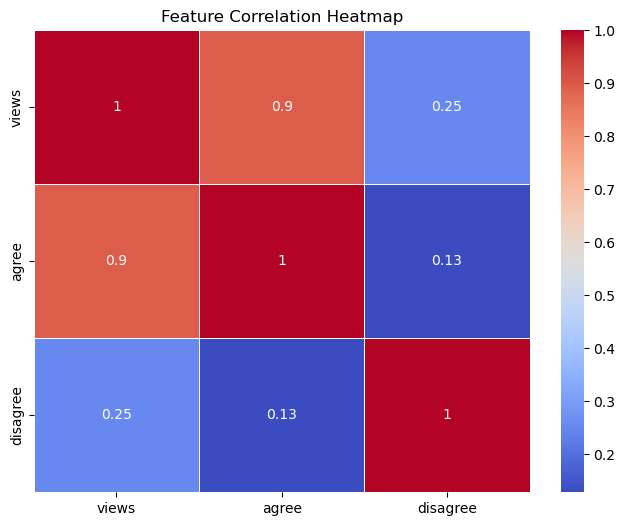

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 'views', 'agree', 'disagree' 피처 간의 상관관계 계산
correlation_matrix = df[['views', 'agree', 'disagree']].corr()

# 상관관계 히트맵 출력
plt.figure(figsize=(8, 6)) # 히트맵 크기 설정
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

### 숫자형 데이터 표준화

In [46]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 조회수 데이터 스케일링
df['views'] = scaler.fit_transform(df[['views']])

In [47]:
# StandardScaler 객체 생성
scaler = StandardScaler()

# 조회수 데이터 스케일링
df['agree'] = scaler.fit_transform(df[['agree']])

In [48]:
# StandardScaler 객체 생성
scaler = StandardScaler()

# 조회수 데이터 스케일링
df['disagree'] = scaler.fit_transform(df[['disagree']])

### Visualization

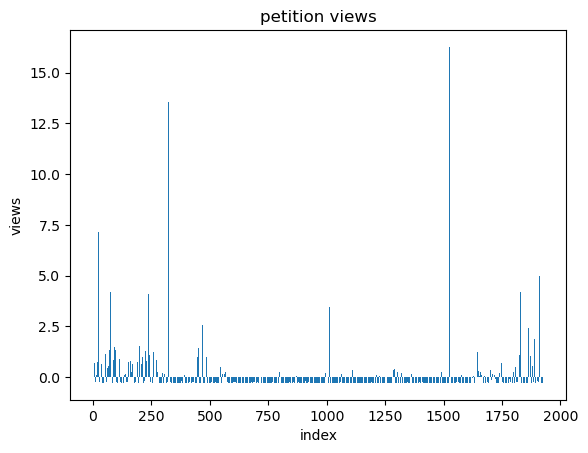

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# 막대 그래프 그리기
plt.bar(df.index, df['views'])
plt.title('petition views')
plt.xlabel('index')
plt.ylabel('views')

plt.show()  # 그래프 보여주기

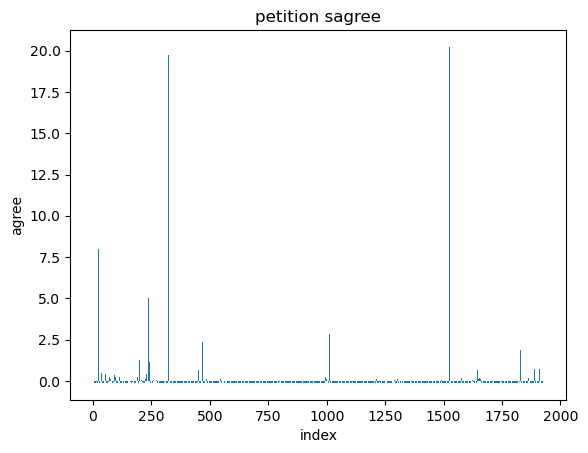

In [52]:
# 막대 그래프 그리기
plt.bar(df.index, df['agree'])
plt.title('petition agree')
plt.xlabel('index')
plt.ylabel('agree')

plt.show()  # 그래프 보여주기

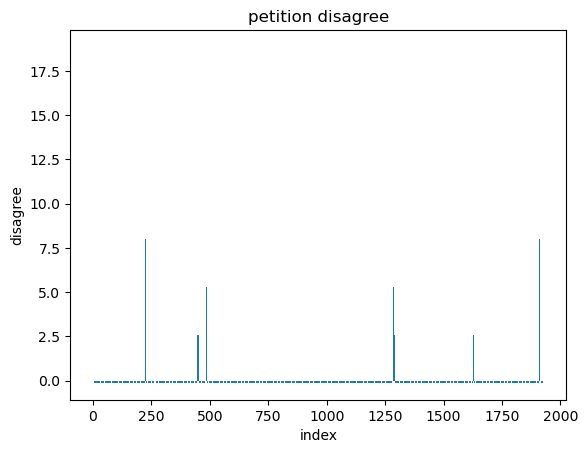

In [53]:
# 막대 그래프 그리기
plt.bar(df.index, df['disagree'])
plt.title('petition disagree')
plt.xlabel('index')
plt.ylabel('disagree')

plt.show()  # 그래프 보여주기

## 4. 모델 훈련

In [54]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt

In [58]:
# 필요한 피처 선택
df_c = df[['title', 'views', 'agree', 'disagree', 'category']]

In [59]:
# '카테고리' 열을 제외한 나머지를 특성 데이터(X)로, '카테고리' 열을 타겟 데이터(y)로 설정
X = df_c.drop('category', axis=1)
y = df_c['category']

In [62]:
# 데이터를 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

,title,views,agree,disagree
427,음대 폐쇄와 실기시험 취소 논의를 요청합니다,-0.279639,-0.127111,-0.132511
141,헬스장에 파워렉 설치를 건의합니다.,0.639635,-0.084070,-0.132511
1023,의과대학의 오프라인 강의를 반대합니다,-0.268824,-0.127111,-0.132511
695,여름 계절학기 전면 온라인 강의로 전환하기를 요구합니다,-0.279639,-0.127111,-0.132511
1803,이번 게시된 이화 홍보 영상 담당자에게 인센티브 지급 바랍니다.,-0.279639,-0.127111,-0.132511
...,...,...,...,...
1132,수강 정정기간 연장 및 수강인원 확충,-0.279639,-0.127111,-0.132511
1296,기숙사 선택입사 요청합니다,-0.279639,-0.127111,-0.132511
861,사이버 캠퍼스 개선,-0.279639,-0.127111,-0.132511
1463,질병휴학 시 등록금 반환해주세요,-0.279639,-0.127111,-0.132511


### 피처벡터화

In [60]:
from konlpy.tag import Okt

okt = Okt()
def tw_tokenizer(text):
    # 입력 인자로 들어온 텍스트를 형태소 단어로 토큰화해 리스트 형태로 반환
    tokens_ko = okt.morphs(text)
    return tokens_ko

### LogisticRegression 모델을 이용한 평가

In [66]:
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(tokenizer=tw_tokenizer)),
    ('lr_clf', LogisticRegression(random_state=42))
])

In [67]:
# '제목' 컬럼과 '카테고리' 컬럼을 사용해야 합니다.
# X_train과 y_train을 앞서 분할한 데이터로 가정합니다.
# 실제 코드에 맞게 데이터를 조정해 주세요.

pipeline.fit(X_train['title'], y_train)

/Users/lenovo/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf_vect',
                 TfidfVectorizer(tokenizer=<function tw_tokenizer at 0x15fa2c5e0>)),
                ('lr_clf', LogisticRegression(random_state=42))])

In [68]:
from sklearn.metrics import accuracy_score

# 테스트 데이터 세트를 이용한 예측
pred = pipeline.predict(X_test['title'])

# 정확도 평가
print('정확도:', accuracy_score(y_test, pred))

정확도: 0.7948051948051948


### 예측 결과 확인

In [69]:
pred

array(['기타', '행정지원', '행정지원', '행정지원', '행정지원', '대학', '행정지원', '행정지원', '행정지원',
       '행정지원', '행정지원', '기타', '학생지원', '생활지원', '행정지원', '행정지원', '행정지원',
       '학생지원', '학생지원', '행정지원', '기타', '행정지원', '행정지원', '행정지원', '대학', '대학',
       '행정지원', '행정지원', '행정지원', '대학', '생활지원', '대학', '행정지원', '행정지원', '행정지원',
       '기타', '대학', '행정지원', '행정지원', '행정지원', '기타', '대학', '행정지원', '행정지원',
       '행정지원', '행정지원', '기타', '행정지원', '행정지원', '행정지원', '학생지원', '기타', '행정지원',
       '행정지원', '행정지원', '기타', '대학', '기타', '생활지원', '행정지원', '대학', '학생지원',
       '대학', '행정지원', '대학', '행정지원', '행정지원', '기타', '대학', '행정지원', '대학',
       '행정지원', '대학', '기타', '행정지원', '행정지원', '행정지원', '행정지원', '기타', '행정지원',
       '행정지원', '행정지원', '기타', '행정지원', '행정지원', '행정지원', '행정지원', '대학', '기타',
       '행정지원', '행정지원', '생활지원', '행정지원', '대학', '생활지원', '행정지원', '행정지원',
       '행정지원', '행정지원', '행정지원', '기타', '대학', '기타', '학생지원', '기타', '행정지원',
       '기타', '행정지원', '행정지원', '행정지원', '행정지원', '학생지원', '행정지원', '행정지원',
       '생활지원', '대학', '대학', '생활지원', '기타', '행정지원', '기타', '행정지원', '기타'

In [70]:
import pandas as pd

# 예측 결과와 X_test['title']을 pandas DataFrame으로 결합
results_df = pd.DataFrame({'test_title': X_test['title'], 'Predicted': pred, 'Answer': y_test})

results_df

,test_title,Predicted,Answer
1852,관광객의 수가 정도를 넘어 선 수준입니다.,기타,기타
1628,졸업식 연기하세요. 대책 마련하세요. 학교가 해야 할 일이니까요.,행정지원,행정지원
614,기말고사 오프라인 시험 금지 요청,행정지원,행정지원
1345,결론은 결국 학기 전면 사이버강의입니다,행정지원,행정지원
414,학기 기말고사를 전면 비대면으로 진행해주십시오,행정지원,행정지원
...,...,...,...
1857,중국의 샤먼대학교처럼 관광객 쿼터제,기타,기타
434,실습도 비대면 선택권 주세요,행정지원,기타
1468,사이버강의 연장해주세요.,행정지원,행정지원
745,기말고사 오프라인 시험을 막아주세요,행정지원,행정지원


In [71]:
results_df.to_csv("final_result.csv", index = False)